In [42]:
from torch import set_grad_enabled, clamp, matmul, Tensor, sum, ones, randn, empty, max, exp
from torch.nn.init import normal_
from random import uniform
from math import pi, sqrt
import matplotlib.pyplot as plt
import random
from numpy import mean

### _I - Setting up_

In [43]:
# Turn off autograd
set_grad_enabled(False)

In [44]:
# Generates a data point sampled uniformly in [0,1]
# If the data is inside the disk centered at (0.5,0.5) of radius 1/2*pi, its label must be 1, else 0
def gen_point():
    center_x, center_y = 0.5, 0.5
    R = 1/sqrt(2*pi)
    
    rand_x, rand_y = uniform(0, 1), uniform(0, 1)
    
    res = 0
    if (rand_x - center_x) ** 2 + (rand_y - center_y) ** 2 <= R ** 2: #inside
        res = 1
        
    return [rand_x, rand_y], res

# Generates N points
def gen_points(N):
    ps = []
    results = []
    for _ in range(N):
        p, res = gen_point()
        ps.append(p)
        results.append(res)
    return ps, results


In [45]:
# One-hot encodes y
def convert_to_one_hot(y):
    y_onehot = empty(y.size(0), 2) #2 because boolean one hot
    y_onehot.zero_()
    y_onehot[range(y.size(0)), y.long()]=1
    return y_onehot

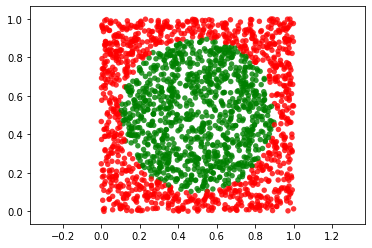

In [46]:
# Generate 1k samples of training data + 1k samples of testing data
all_points, all_results = gen_points(2000)

# Plot the data
fig, ax = plt.subplots()
plt.axis('equal')
for p,r in zip(all_points, all_results):
    ax.scatter(p[0], p[1], alpha=0.8, c='green' if r else 'red', edgecolors='none', s=30)

In [47]:
# Convert to tensors
all_points = Tensor(all_points)
all_results = Tensor(all_results)
all_results_one_hot = convert_to_one_hot(all_results)

# Split the dataset
train_pts, test_pts = all_points[:1000], all_points[1000:]
train_res, test_res = all_results[:1000], all_results[1000:]
train_res_1h, test_res_1h = all_results_one_hot[:1000], all_results_one_hot[1000:]

In [48]:
# Normalize the datasets
mean,std = train_pts.mean(), train_pts.std()
train_pts.sub_(mean).div_(std)
test_pts.sub_(mean).div_(std)

tensor([[ 0.5331, -1.3304],
        [ 1.7080,  1.6318],
        [-0.8456, -1.1627],
        ...,
        [-0.3546,  0.9026],
        [-0.4757,  0.3902],
        [-1.1338, -0.4809]])

### _II - Defining network structures_

In [49]:
# Interface
class Module (object):
    def __init__(self):
        self.x = None           # The input to the current module
        self.prev_grad = None   # Gradient at the output of this module
    
    # Forward-pass method
    def forward (self ,x):
        raise NotImplementedError
        
    # Backward propagation method
    def backward (self , prev_grad):
        raise NotImplementedError
        
    # Update method
    def step(self, lr):
        raise NotImplementedError

In [63]:
# Fully connected layer
class Linear(Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.w = randn(in_dim, out_dim) * 0.2 # Random weights from normal dist
        self.b = randn(1, out_dim) * 0.2      # Random bias from normal dist
                                              # Scale with 0.2 not to have inf values and losses
        #print('w', self.w)
        #print('b', self.b)
        
    def forward(self, x):
        self.x = x
        return (x @ self.w) + self.b          # Without an activation function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                  # Cache the grad at the output for weight update.      
        current_grad = (prev_grad @ self.w.t())     # Compute the gradient wrt x
        return current_grad
        
    def step(self, lr):
        self.w -= lr * (self.x.t() @ self.prev_grad)    # Multiply the grad at output with dy/dw to update the weights
        self.b -= lr * (self.prev_grad.sum(dim=0))      # dy/db = 1. then dL / db = dy, which is the grad at the output
    

In [64]:
# Sequential structure to combine several modules
class Sequential(Module):
    def __init__(self, module_list):
        self.module_list = module_list
        
    def forward(self, x):
        out = self.module_list[0].forward(x)
        for module in self.module_list[1:]:
            out = module.forward(out)
        return out
    
    def backward(self, gradwrtoutput):
        for model in self.module_list[::-1]:
            gradwrtoutput  = model.backward(gradwrtoutput)
            
    def step(self, lr):
        for module in self.module_list:
            module.step(lr)

### _III - Defining activation functions_

In [60]:
# Tanh activation function
class Tanh(Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.x = x
        return ((exp(x) - exp(-x)) / (exp(x) + exp(-x)))    # Tanh function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                          # Cache the gradient at the output
        tanh_x = (exp(self.x) - exp(-self.x)) / (exp(self.x) + exp(-self.x))   # Tanh of x
        curr_grad = prev_grad (1 - (tanh_x)**2)             # Current gradient 
        return curr_grad
    
    def step(self, lr):
        pass

In [61]:
# ReLu activation function
class ReLU(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return x.clamp(min = 0)       # Negative values -> 0, positive values stay the same (relu = max(0,x))
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        curr_grad = prev_grad.clone() # Copy it for returning the new gradient
        curr_grad[self.x < 0] = 0     # Relu = max(0,x), grad_relu = 0 if x <= 0 else 1
        return curr_grad
    
    def step(self, lr):
        pass    

In [51]:
# Sigmoid activation function
class Sigmoid(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return 1 / (1 + exp(-x))      # Sigmoid function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        sigmoid_x = 1 / (1 + exp(-self.x))                    # Sigmoid of x
        curr_grad = prev_grad * sigmoid_x * (1 - sigmoid_x)   # Current gradient
        return curr_grad

    def step(self, lr):
        pass
    

### _IV - Defining  cost functions_

In [54]:
# Computes the Mean Squared Error & Gradient at output
def mse(pred, true):
    return sum((pred - true)**2),  2* (pred - true)

In [56]:
# Instanciates a model with respect to the model id given as input to the function
def model_selector(mid):
    if mid == 0:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2)])
        return model
    elif mid == 1:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2), Sigmoid() ])
        return model
        

### _V - Training and measuring performance_

In [62]:
# Trains the model over n epochs

### train_res_1H ???

def train(model, train_pts, train_res_1h, n_epoch, lr):
    model_history = dict()
    
    train_loss = []
    for e in range(n_epoch):
        pred = model.forward(train_pts)
        loss, grad_at_output = mse(pred, train_res_1h.view(-1, 2))
        model.backward(grad_at_output)
        model.step(lr)
        train_loss.append(loss.item())
        
    model_history['train_loss'] = train_loss
    return model_history

In [ ]:
# Computes accuracy
def compute_acc(model, test_pts, test_res):
    n_samples = test_pts.size(0)
    pred = model.forward(test_pts)
    _, indices = max(pred.view(-1,2), 1)
    acc_target = (sum(indices.view(-1,1) == test_res.view(-1, 1)) / float(n_samples) * 100).item()
    return acc_target

In [57]:
# Performs a k-fold cross validation
def cross_val_score(mid, train_inp, train_res, train_res_1h, n_epoch, lr, k_folds=5):
    len_train = train_inp.size(0)
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    accs = []
    for k in range(k_folds):
        model = model_selector(mid)  # Init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        # Train the model with k-1 training fold
        history = train(model, train_inp[train_indices], train_res_1h[train_indices], n_epoch, lr)
        
        # Compute the accuracy on 1 validation fold
        acc = compute_acc(model, train_inp[val_indices], train_res[val_indices]) 
        accs.append(acc)
        #print('fold=', k, ' acc = ', acc)
    return mean(accs)

In [59]:
# Grid search for the sigmoid model
m_ids = [1]
lrs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
epochs = [50,100,150,200,250]

for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_res,train_res_1h, epoch, lr)
            print(mid, lr, epoch, avg)

TypeError: 'Tensor' object is not callable

In [ ]:
# Grid search for the other model
m_ids = [0]
lrs = [0.00001,0.00002,0.00003,0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009]
epochs = [50,100,150,200,250]
for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_res,train_res_1h, epoch, lr)
            print(mid, lr, epoch, avg)

In [197]:
# Test the performance of the sigmoid model with tuned hyper parameters 
model_sigmoid = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2), Sigmoid() ])
history_sigmoid = train(model_sigmoid, train_pts, train_res_1h, 250, 0.004)
acc_sigmoid = compute_acc(model_sigmoid, test_pts,test_res)
print(acc_sigmoid)

95.5999984741211


In [200]:
# Test the performance of the other model with tuned hyper parameters
model_relu =  Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2)])
history_relu = train(model_relu, train_pts, train_res_1h, 250, 0.00005)
acc_relu = compute_acc(model_relu, test_pts,test_res)
print(acc_relu)

96.5
